In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash 

--2021-11-08 03:11:46--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-11-08 03:11:46--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-11-08 03:11:46--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:44

In [2]:
import sparknlp
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 3.3.2
Apache Spark version: 3.0.3


In [79]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sparknlp.base import *
from sparknlp.annotator import *

from pyspark.sql.functions import col 
from sparknlp.pretrained import PretrainedPipeline

In [4]:
train_dataset = spark.read.option('header', True).csv("/content/drive/MyDrive/AAA/sentiment_dataset/aclimdb_train.csv")
train_dataset.show(5) 

+--------------------+--------+
|                text|   label|
+--------------------+--------+
|This is an Excell...|positive|
|The Sarah Silverm...|positive|
|"Prom Night" is a...|negative|
|So often a band w...|positive|
|"Pet Sematary" is...|positive|
+--------------------+--------+
only showing top 5 rows



In [8]:
train_dataset.groupBy("label").count().orderBy(col("count").desc()).show() 

+--------+-----+
|   label|count|
+--------+-----+
|positive|12500|
|negative|12500|
+--------+-----+



In [5]:
test_dataset = spark.read.option('header', True).csv("/content/drive/MyDrive/AAA/sentiment_dataset/aclimdb_test.csv")
test_dataset.show(5) 

+--------------------+--------+
|                text|   label|
+--------------------+--------+
|The Second Woman ...|negative|
|In my opinion the...|positive|
|I am listening to...|positive|
|Before I speak my...|negative|
|ManBearPig is a p...|positive|
+--------------------+--------+
only showing top 5 rows



In [9]:
test_dataset.groupBy("label").count().orderBy(col("count").desc()).show() 

+--------+-----+
|   label|count|
+--------+-----+
|positive|12500|
|negative|12500|
+--------+-----+



In [10]:
# Dropping null value 
train_dataset = train_dataset.na.drop() 
test_dataset = test_dataset.na.drop() 

In [11]:
# Dropping duplicate value of train_dataset 
train_dataset = train_dataset.dropDuplicates() 

In [12]:
# Shape of train and test dataset 
print("shape of train_dataset is :{} {}".format(train_dataset.count(), len(train_dataset.columns)))
print("Shape of test_dataset is :{} {}".format(test_dataset.count(), len(test_dataset.columns))) 

shape of train_dataset is :24904 2
Shape of test_dataset is :25000 2


In [13]:
# Dividing dataset 
train, valid = train_dataset.randomSplit([.9, .1], seed=42) 
print("Shape of train is :{} {}".format(train.count(), len(train.columns)))
print("Shape of valid is :{} {}".format(valid.count(), len(valid.columns))) 

Shape of train is :22369 2
Shape of valid is :2535 2


### Define Pipeline

In [18]:
# define document 
document = DocumentAssembler().setInputCol('text').setOutputCol('document').setCleanupMode('shrink')

# define sentence detector 
sentence_detector = SentenceDetector().setInputCols(["document"]).setOutputCol("sentence")

# define tokenizer 
tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

# define lemmatizer 
lemmatizer = Lemmatizer().setInputCols(["token"]).setOutputCol("lemma").setDictionary("/content/drive/MyDrive/AAA/sentiment_dataset/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")

# define sentence detector 
sentiment_detector = SentimentDetector().setInputCols(["lemma", "sentence"]).setOutputCol("sentiment_score").setDictionary("/content/drive/MyDrive/AAA/sentiment_dataset/default-sentiment-dict.txt", ",")

# define finisher 
finisher = Finisher().setInputCols(["sentiment_score"]).setOutputCols(["sentiment"])

# define pipeline 
pipeline = Pipeline(
    stages = [
              document, 
              sentence_detector,
              tokenizer,
              lemmatizer,
              sentiment_detector,
              finisher
    ])

In [19]:
model = pipeline.fit(train)

In [24]:
# Analyzing pipeline transformation outcome 
pred_valid = model.transform(valid)
pred_valid.show() 

+--------------------+--------+----------+
|                text|   label| sentiment|
+--------------------+--------+----------+
|After Racism, Rur...|positive|[positive]|
|Ah, Lucio Fulci, ...|negative|[positive]|
|I waited until th...|positive|[positive]|
|In War, Inc we fi...|positive|[positive]|
|The message of a ...|positive|[positive]|
|Two days after se...|negative|[negative]|
|xica da Silva is ...|positive|[positive]|
|All you really ne...|negative|[positive]|
|Bill Paxton, of A...|positive|[positive]|
|I went to see it ...|positive|[positive]|
|I wish I could sa...|negative|[positive]|
|I've read all the...|negative|[positive]|
|If you are the so...|negative|[negative]|
|Movie: There are ...|negative|[positive]|
|The only possible...|negative|[positive]|
|This early B entr...|negative|[positive]|
|Well, basically, ...|negative|[negative]|
|Clair Denis again...|positive|[positive]|
|Cliff Robertson a...|negative|[positive]|
|Daniel Day Lewis ...|positive|[positive]|
+----------

In [32]:
pred_valid.select('label', 'text', 'sentiment').show() 

+--------+--------------------+----------+
|   label|                text| sentiment|
+--------+--------------------+----------+
|positive|After Racism, Rur...|[positive]|
|negative|Ah, Lucio Fulci, ...|[positive]|
|positive|I waited until th...|[positive]|
|positive|In War, Inc we fi...|[positive]|
|positive|The message of a ...|[positive]|
|negative|Two days after se...|[negative]|
|positive|xica da Silva is ...|[positive]|
|negative|All you really ne...|[positive]|
|positive|Bill Paxton, of A...|[positive]|
|positive|I went to see it ...|[positive]|
|negative|I wish I could sa...|[positive]|
|negative|I've read all the...|[positive]|
|negative|If you are the so...|[negative]|
|negative|Movie: There are ...|[positive]|
|negative|The only possible...|[positive]|
|negative|This early B entr...|[positive]|
|negative|Well, basically, ...|[negative]|
|positive|Clair Denis again...|[positive]|
|negative|Cliff Robertson a...|[positive]|
|positive|Daniel Day Lewis ...|[positive]|
+--------+-

In [33]:
pred_valid_df = pred_valid.select('label', 'text', 'sentiment').toPandas()

In [35]:
pred_valid_df 

,label,text,sentiment
0,positive,"After Racism, Rural exodus -also known as migr...",[positive]
1,negative,"Ah, Lucio Fulci, rest in peace. This infamous ...",[positive]
2,positive,I waited until the 4th of July to write this b...,[positive]
3,positive,"In War, Inc we find the logical extension of t...",[positive]
4,positive,The message of a world on the brink of war is ...,[positive]
...,...,...,...
2530,positive,One of the great things about many of the supe...,[positive]
2531,positive,"Overall, I thought it a very nice movie - I ha...",[positive]
2532,negative,This 2003 made for TV movie was shown on a wom...,[negative]
2533,positive,Very nicely done movie. It does stay in your m...,[positive]


In [40]:
pred_valid_df['sentiment'] = pred_valid_df['sentiment'].apply(lambda x: x[0]) 

In [41]:
print("Accuracy score is :{}".format(accuracy_score(pred_valid_df['sentiment'], pred_valid_df['label']))) 

Accuracy score is :0.5857988165680473


In [42]:
# classification report 
print(classification_report(pred_valid_df['sentiment'], pred_valid_df['label'])) 

              precision    recall  f1-score   support

    negative       0.26      0.74      0.38       435
    positive       0.91      0.55      0.69      2100

    accuracy                           0.59      2535
   macro avg       0.58      0.65      0.53      2535
weighted avg       0.80      0.59      0.64      2535



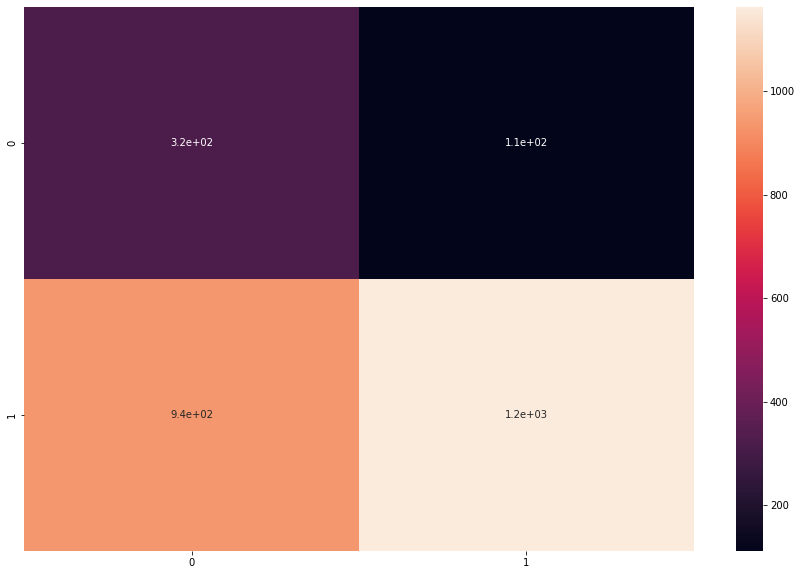

In [43]:
# Confusion Matrix 
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(pred_valid_df['sentiment'], pred_valid_df['label']), annot=True)
plt.show() 

In [76]:
# pred_valid.where(array_contains(pred_valid.sentiment, "positive")).show(10,False) 

In [46]:
pred_test = model.transform(test_dataset) 

In [47]:
pred_test.select('text', 'label', 'sentiment').show() 

+--------------------+--------+----------+
|                text|   label| sentiment|
+--------------------+--------+----------+
|The Second Woman ...|negative|[positive]|
|In my opinion the...|positive|[positive]|
|I am listening to...|positive|[positive]|
|Before I speak my...|negative|[positive]|
|ManBearPig is a p...|positive|[positive]|
|A buddy and I wen...|negative|[negative]|
|It is incredible ...|negative|[positive]|
|Dire! Dismal! Awf...|negative|[positive]|
|HLOTS was an outs...|positive|[positive]|
|This is just one ...|negative|[positive]|
|This movie had th...|negative|[positive]|
|The 80s were over...|positive|[positive]|
|The tunes are the...|positive|[positive]|
|Having recently s...|positive|[positive]|
|My favorite film ...|positive|[positive]|
|This movie just m...|positive|[positive]|
|This is the worst...|negative|[positive]|
|This was a nice f...|positive|[positive]|
|I don't know, may...|negative|[positive]|
|After wasting 2 h...|negative|[positive]|
+----------

In [48]:
pred_test_df = pred_test.select('text', 'label', 'sentiment').toPandas() 

In [50]:
pred_test_df['sentiment'] = pred_test_df['sentiment'].apply(lambda x: x[0]) 
pred_test_df 

,text,label,sentiment
0,The Second Woman is about the story of a myste...,negative,positive
1,"In my opinion the directing, editing, lighting...",positive,positive
2,"I am listening to Istanbul, intent, my eyes cl...",positive,positive
3,"Before I speak my piece, I would like to make ...",negative,positive
4,ManBearPig is a pretty funny episode of South ...,positive,positive
...,...,...,...
24995,This show has an amazing plot with good and re...,positive,positive
24996,I don't know what Dick steel was talking about...,positive,positive
24997,Aaliyah blows all the female cast members out ...,positive,positive
24998,the movie is complete disaster. i don't know w...,negative,positive


### Using Another Pipeline 

In [51]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained() \
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
sentimentdl = SentimentDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("label")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)

pipeline = Pipeline(
    stages = [
        document,
        use,
        sentimentdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [52]:
model = pipeline.fit(train)

In [53]:
# Analyzing pipeline transformation outcome 
pred_valid = model.transform(valid)
pred_valid.show() 

+--------------------+--------+--------------------+--------------------+--------------------+
|                text|   label|            document| sentence_embeddings|               class|
+--------------------+--------+--------------------+--------------------+--------------------+
|After Racism, Rur...|positive|[[document, 0, 18...|[[sentence_embedd...|[[category, 0, 18...|
|Ah, Lucio Fulci, ...|negative|[[document, 0, 21...|[[sentence_embedd...|[[category, 0, 21...|
|I waited until th...|positive|[[document, 0, 43...|[[sentence_embedd...|[[category, 0, 43...|
|In War, Inc we fi...|positive|[[document, 0, 18...|[[sentence_embedd...|[[category, 0, 18...|
|The message of a ...|positive|[[document, 0, 19...|[[sentence_embedd...|[[category, 0, 19...|
|Two days after se...|negative|[[document, 0, 51...|[[sentence_embedd...|[[category, 0, 51...|
|xica da Silva is ...|positive|[[document, 0, 91...|[[sentence_embedd...|[[category, 0, 91...|
|All you really ne...|negative|[[document, 0, 10..

In [54]:
pred_valid.select('label', 'text', 'class.result').show() 

+--------+--------------------+----------+
|   label|                text|    result|
+--------+--------------------+----------+
|positive|After Racism, Rur...|[positive]|
|negative|Ah, Lucio Fulci, ...|[negative]|
|positive|I waited until th...|[positive]|
|positive|In War, Inc we fi...|[positive]|
|positive|The message of a ...|[positive]|
|negative|Two days after se...|[negative]|
|positive|xica da Silva is ...|[positive]|
|negative|All you really ne...|[negative]|
|positive|Bill Paxton, of A...|[positive]|
|positive|I went to see it ...|[positive]|
|negative|I wish I could sa...|[negative]|
|negative|I've read all the...|[positive]|
|negative|If you are the so...|[positive]|
|negative|Movie: There are ...|[negative]|
|negative|The only possible...|[negative]|
|negative|This early B entr...|[positive]|
|negative|Well, basically, ...|[negative]|
|positive|Clair Denis again...|[positive]|
|negative|Cliff Robertson a...|[negative]|
|positive|Daniel Day Lewis ...|[positive]|
+--------+-

In [56]:
pred_valid_df = pred_valid.select('text', 'label', 'class.result').toPandas() 

In [57]:
pred_valid_df['result'] = pred_valid_df['result'].apply(lambda x: x[0]) 

In [58]:
print("Accuracy score is :{}".format(accuracy_score(pred_valid_df['result'], pred_valid_df['label']))) 

Accuracy score is :0.8382642998027613


In [59]:
# classification report 
print(classification_report(pred_valid_df['result'], pred_valid_df['label'])) 

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84      1144
     neutral       0.00      0.00      0.00        54
    positive       0.88      0.83      0.85      1337

    accuracy                           0.84      2535
   macro avg       0.56      0.57      0.56      2535
weighted avg       0.82      0.84      0.83      2535



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


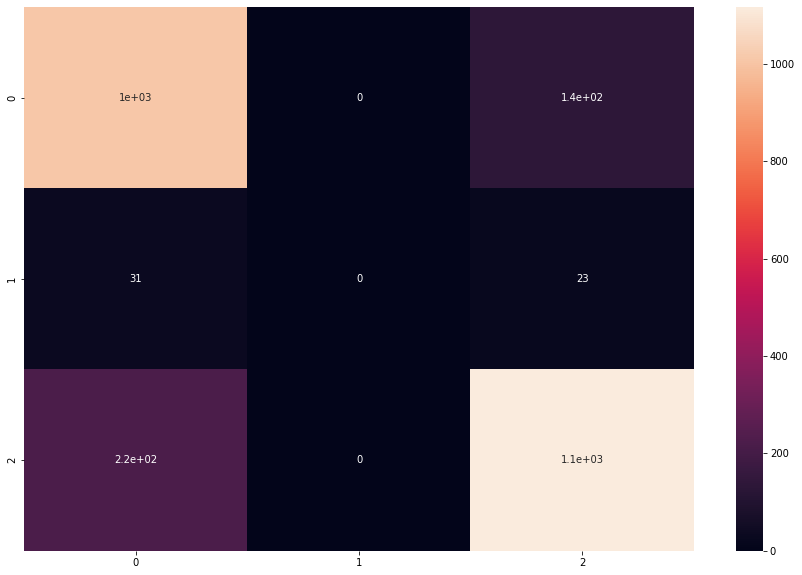

In [60]:
# Confusion Matrix 
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(pred_valid_df['result'], pred_valid_df['label']), annot=True)
plt.show() 

### Using Another Pipeline 

In [63]:
# actual content is inside Text column 
document = DocumentAssembler().setInputCol("text").setOutputCol('document')

# downloading pretrained embeddings 
use = UniversalSentenceEncoder.pretrained().setInputCols(["document"]).setOutputCol("sentence_embeddings") 

# classifier 
classifierdl = ClassifierDLApproach().setInputCols(['sentence_embeddings']).setOutputCol('class').setLabelColumn("label").setMaxEpochs(5).setEnableOutputLogs(True) 

# pipeline 
pipeline = Pipeline(
    stages = [
              document, 
              use, 
              classifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [65]:
pipelineModel = pipeline.fit(train) 

In [66]:
pred_valid = pipelineModel.transform(valid) 

In [69]:
pred_valid.select('label', 'text', 'class.result').show() 

+--------+--------------------+----------+
|   label|                text|    result|
+--------+--------------------+----------+
|positive|After Racism, Rur...|[positive]|
|negative|Ah, Lucio Fulci, ...|[negative]|
|positive|I waited until th...|[positive]|
|positive|In War, Inc we fi...|[positive]|
|positive|The message of a ...|[positive]|
|negative|Two days after se...|[negative]|
|positive|xica da Silva is ...|[positive]|
|negative|All you really ne...|[negative]|
|positive|Bill Paxton, of A...|[positive]|
|positive|I went to see it ...|[positive]|
|negative|I wish I could sa...|[negative]|
|negative|I've read all the...|[positive]|
|negative|If you are the so...|[positive]|
|negative|Movie: There are ...|[negative]|
|negative|The only possible...|[negative]|
|negative|This early B entr...|[positive]|
|negative|Well, basically, ...|[negative]|
|positive|Clair Denis again...|[positive]|
|negative|Cliff Robertson a...|[negative]|
|positive|Daniel Day Lewis ...|[positive]|
+--------+-

In [70]:
pred_valid_df = pred_valid.select('label', 'text', 'class.result').toPandas() 

In [71]:
pred_valid_df['result'] = pred_valid_df['result'].apply(lambda x: x[0]) 

In [73]:
print("Accuracy score is :{}".format(accuracy_score(pred_valid_df['result'], pred_valid_df['label'])))

Accuracy score is :0.8469428007889547


In [74]:
# classification report 
print(classification_report(pred_valid_df['result'], pred_valid_df['label'])) 

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85      1299
    positive       0.83      0.86      0.85      1236

    accuracy                           0.85      2535
   macro avg       0.85      0.85      0.85      2535
weighted avg       0.85      0.85      0.85      2535



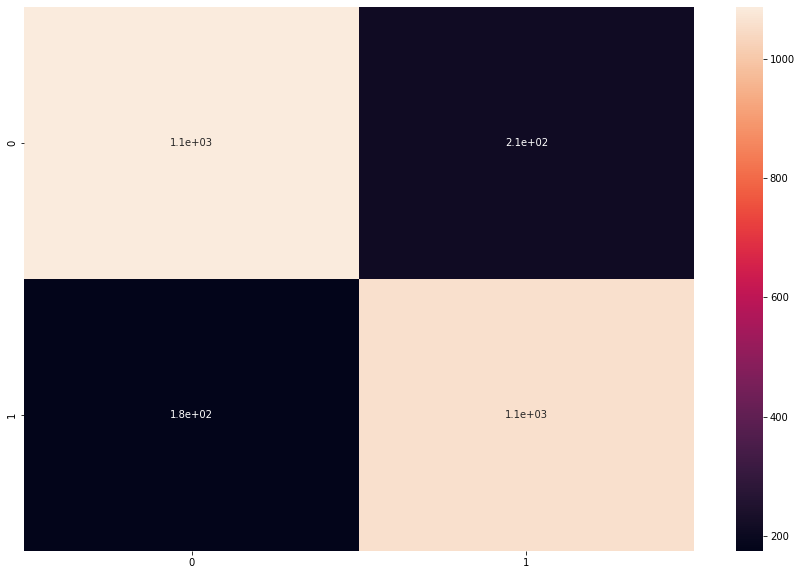

In [75]:
# Confusion Matrix 
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(pred_valid_df['result'], pred_valid_df['label']), annot=True)
plt.show() 

# Sentiment Analysis Using Pipeline

In [80]:
pipeline = PretrainedPipeline("analyze_sentiment", lang='en') 

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [81]:
data = ["I felt so disapointed to see this very uninspired film. I recommend others to awoid this movie is not good.", 
        "This was movie was amesome, everything was nice."] 

In [82]:
result = pipeline.annotate(data)

In [83]:
[(r['sentence'], r['sentiment']) for r in result] 

[(['I felt so disapointed to see this very uninspired film.',
   'I recommend others to awoid this movie is not good.'],
  ['positive', 'negative']),
 (['This was movie was amesome, everything was nice.'], ['negative'])]

In [84]:
result

[{'checked': ['I',
   'felt',
   'so',
   'disappointed',
   'to',
   'see',
   'this',
   'very',
   'uninspired',
   'film',
   '.',
   'I',
   'recommend',
   'others',
   'to',
   'avoid',
   'this',
   'movie',
   'is',
   'not',
   'good',
   '.'],
  'document': ['I felt so disapointed to see this very uninspired film. I recommend others to awoid this movie is not good.'],
  'sentence': ['I felt so disapointed to see this very uninspired film.',
   'I recommend others to awoid this movie is not good.'],
  'sentiment': ['positive', 'negative'],
  'token': ['I',
   'felt',
   'so',
   'disapointed',
   'to',
   'see',
   'this',
   'very',
   'uninspired',
   'film',
   '.',
   'I',
   'recommend',
   'others',
   'to',
   'awoid',
   'this',
   'movie',
   'is',
   'not',
   'good',
   '.']},
 {'checked': ['This',
   'was',
   'movie',
   'was',
   'awesome',
   ',',
   'everything',
   'was',
   'nice',
   '.'],
  'document': ['This was movie was amesome, everything was nice.'],
